<a href="https://colab.research.google.com/github/indrasuthar07/AGE-GENDER-DETECTION-ML-/blob/main/Age_%26_Gender_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#kaggle api
!kaggle datasets download jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 95% 316M/331M [00:00<00:00, 275MB/s]
100% 331M/331M [00:01<00:00, 331MB/s]


In [ ]:
!ls


kaggle.json  sample_data  utkface-new.zip


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


Loading the Dataset

In [ ]:
#extract zip file
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
BASE_DIR = '/content/UTKFace'

In [ ]:
#labels = age,gender
image_paths = []
age_labels =[]
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
  image_path = os.path.join(BASE_DIR, filename)
  temp = filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame()
df['image'],df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/24_0_3_20170119165651324.jpg....,24,0
1,/content/UTKFace/58_0_3_20170119211651056.jpg....,58,0
2,/content/UTKFace/50_1_0_20170105162633419.jpg....,50,1
3,/content/UTKFace/28_1_2_20170116170937606.jpg....,28,1
4,/content/UTKFace/51_1_0_20170104170143329.jpg....,51,1


In [ ]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

Exploratory Data Analysis

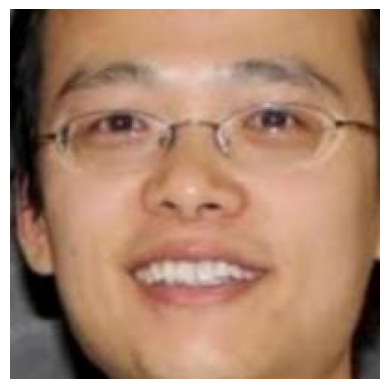

In [ ]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

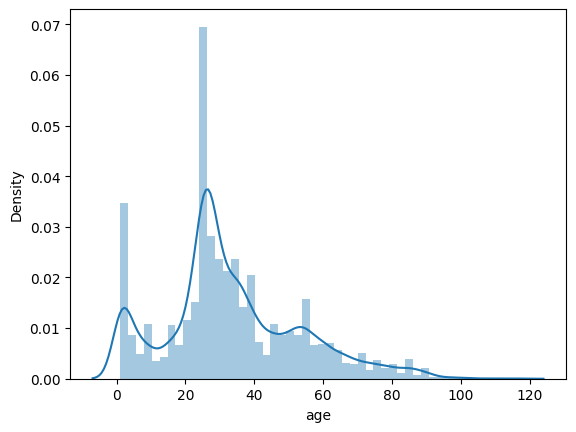

In [ ]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

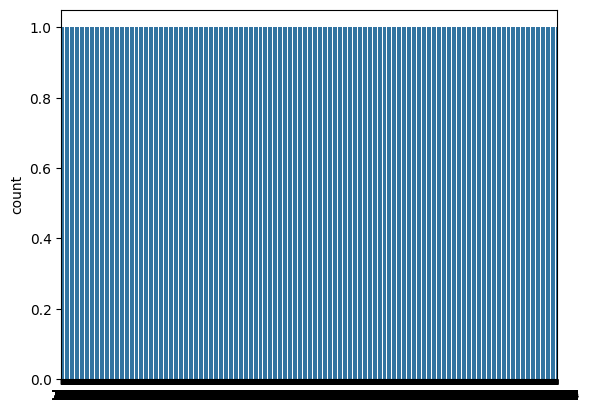

In [ ]:
sns.countplot(df['gender'])

In [ ]:
#to display grid of imags
plt.figure(figsize=(20,20))
files = df.iloc[0:25]
for index, file, age, gender in files.itertuples():
  plt.subplot(5,5,index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f'Age: {age} Gender: {gender_dict[gender]}')
  plt.axis('off')

Feature Extraction

In [ ]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image,color_mode='grayscale')
    img = img.resize((128,128), Image.Resampling.LANCZOS)
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features),128,128,1)
  return features


In [ ]:
x = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
x.shape

(23708, 128, 128, 1)

In [ ]:
#normalize the images
x = x/255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
input_shape = (128,128,1)

**Model Creation**

In [ ]:
inputs = Input(input_shape)
#convolutional layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
flatten = Flatten()(maxp_3)

#fully connceted layers
dense_1 = Dense(128, activation='relu')(flatten)
dense_2 = Dense(70, activation='relu')(dense_1)

dropout_1 = Dropout(0.3)(dense_2)
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_1)

model = Model(inputs=inputs, outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics=['accuracy', 'mae'])


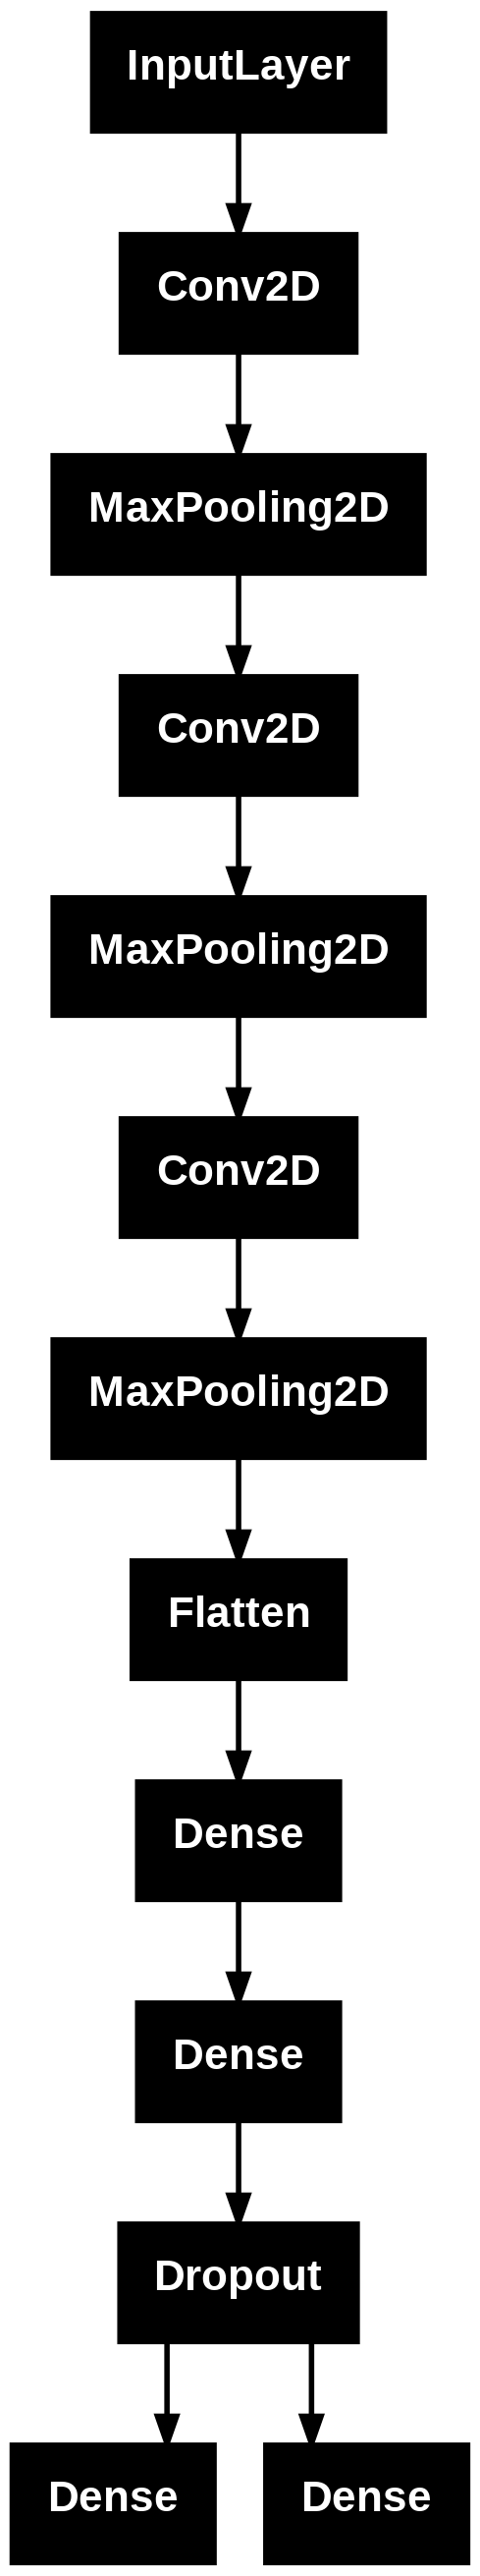

In [ ]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
history = model.fit(x, [y_gender, y_age], validation_split=0.2, batch_size=32, epochs=15)

KeyboardInterrupt: 

plot the Results

<Figure size 640x480 with 0 Axes>

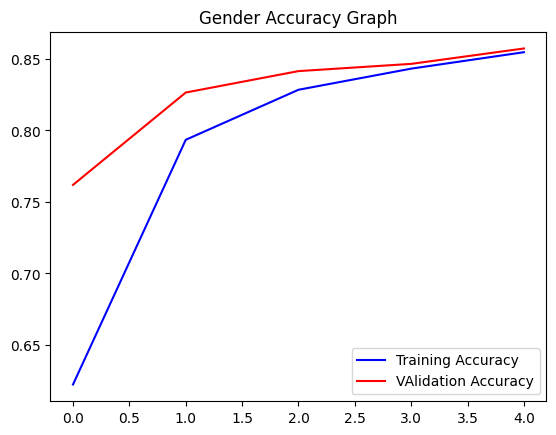

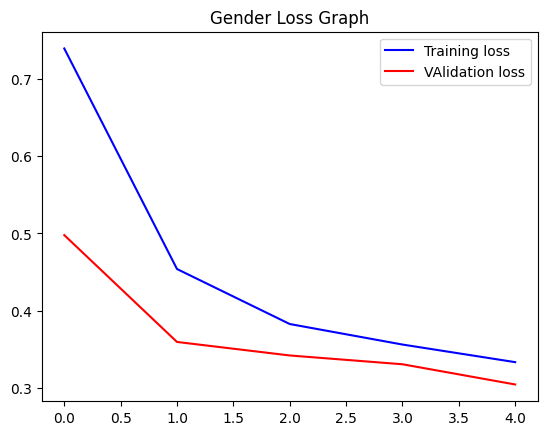

<Figure size 640x480 with 0 Axes>

In [ ]:
#ploting results for gender
acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='VAlidation Accuracy')
plt.title('Gender Accuracy Graph')
plt.legend()
plt.figure()


loss = history.history['gender_output_loss']
val_loss = history.history['val_gender_output_loss']

plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label='VAlidation loss')
plt.title('Gender Loss Graph')
plt.legend()
plt.figure()


<Figure size 640x480 with 0 Axes>

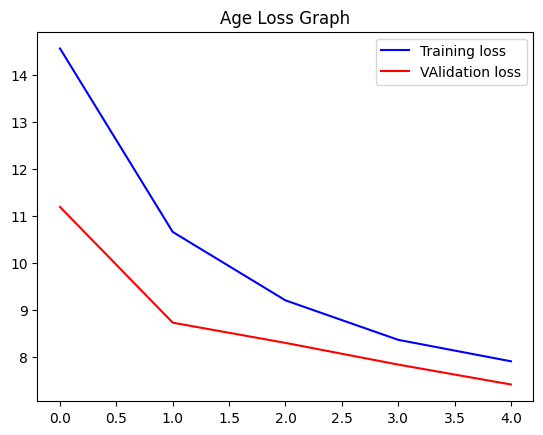

<Figure size 640x480 with 0 Axes>

In [ ]:
#ploting results for age
loss = history.history['age_output_loss']
val_loss = history.history['val_age_output_loss']

plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label='VAlidation loss')
plt.title('Age Loss Graph')
plt.legend()
plt.figure()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Predicted Gender: Male   Predicted age: 44


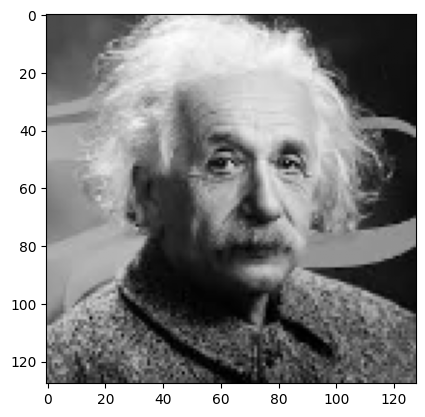

In [ ]:
#prediction with test Data
img_path = '/content/einstien.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128, 128))
img = img / 255.0
img_input = img.reshape(1, 128, 128, 1)
pred = model.predict(img_input)
pred_gender = gender_dict[round((pred[0][0][0]))]
pred_age = round(pred[1][0][0])
print('Predicted Gender:', pred_gender, '  Predicted age:', pred_age)
plt.imshow(img_input.reshape(128,128), cmap='gray')